In [10]:
import numpy as np
from qutip import *
import dask
from dask import delayed
import dask.bag as db
from dask.distributed import Client, LocalCluster,progress
from tqdm import tqdm
import importlib
import functions_fbq
importlib.reload(functions_fbq)
from functions_fbq import *
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from figurestyle import *
figure_features()
# refresh the functions_fbq.py file if it has been changed
# %load_ext autoreload
# %autoreload 2

In [8]:
# Crear un clúster local de Dask y un cliente para conectarse a él
cluster = LocalCluster(n_workers=20, threads_per_worker=1)
client = Client(cluster)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
c:\Users\jc269556\Anaconda3\envs\parallel\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55297 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:55298
INFO:distributed.scheduler:  dashboard at:           127.0.0.1:55297
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:55317'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:55301'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:55318'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:55302'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:55319'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:55303'
INFO:distrib

In [12]:
Ec = 40e9
EDelta = 20e9
eigvals = 2
phi_ext = np.pi

El_list = np.logspace(np.log10(10e6), np.log10(50e9), 50)
r_list = np.linspace(0.01, 0.99, 50)
El_r_pairs = [(El, r) for El in El_list for r in r_list]

f01_list = np.zeros((len(El_list), len(r_list)))
phi_matrix_elements_list = np.zeros((len(El_list), len(r_list)))
n_matrix_elements_list = np.zeros((len(El_list), len(r_list)))
dHdr_matrix_elements_list = np.zeros((len(El_list), len(r_list)))
d2E01dphi2_list = np.zeros((len(El_list), len(r_list)))

In [18]:
np.real(eigenenergies_fbq(Ec, 0.05e9, EDelta, np.pi, 0.05, N = 100, eigvals = 2))[0]

-3349045636.881246

In [13]:
@delayed
def process_r(El, r):
    eigvals_list, _, matrix_op_sqr_list = eigensystem_and_matrix_elements_sqr_fbq(Ec, El, EDelta, phi_ext, r,N = 100, eigvals = eigvals)
    f01 = np.real(eigvals_list[1] - eigvals_list[0])
    n_matrix_element = matrix_op_sqr_list[0]
    phi_matrix_element = matrix_op_sqr_list[1]
    dH_dr_element = matrix_op_sqr_list[2]

    phi_ext_list_lower = np.linspace(phi_ext - 0.01, phi_ext, 5, endpoint=False)
    phi_ext_list_upper = np.linspace(phi_ext, phi_ext + 0.01, 6, endpoint=True)[1:]
    eigvals_list_lower = np.array([np.real(eigenenergies_fbq(Ec, El, EDelta, phi_ext_aux, r, N = 100, eigvals = 2)[1] - eigenenergies_fbq(Ec, El, EDelta, 0, r, N = 50, eigvals = 2)[0]) for phi_ext_aux in phi_ext_list_lower])
    eigvals_list_upper = np.array([np.real(eigenenergies_fbq(Ec, El, EDelta, phi_ext_aux, r, N = 100, eigvals = 2)[1] - eigenenergies_fbq(Ec, El, EDelta, 0, r, N = 50, eigvals = 2)[0]) for phi_ext_aux in phi_ext_list_upper])
    phi_ext_list = np.concatenate([phi_ext_list_lower, phi_ext, phi_ext_list_upper])
    eigvals_phi_ext_list = np.concatenate([eigvals_list_lower, f01, eigvals_list_upper])
    # phi_ext_list = np.concatenate([-phi_ext_list[::-1][0:-1], phi_ext_list])
    # eigvals_list = np.concatenate([eigvals_list[::-1][0:-1], eigvals_list])

    cubic_spline = CubicSpline(phi_ext_list, eigvals_phi_ext_list)
    second_derivative_spline = cubic_spline.derivative(2)
    second_derivative_x0 = second_derivative_spline(phi_ext)

    # dE01_dphi = np.gradient(eigvals_phi_ext_list, phi_ext_list, edge_order=1)
    # d2E01_dphi2 = np.gradient(dE01_dphi, phi_ext_list, edge_order=1)
    # d2E01dphi2 = d2E01_dphi2[len(phi_ext_list) // 2]

    return f01, phi_matrix_element, n_matrix_element, dH_dr_element, second_derivative_x0


In [14]:
# Crear un dask bag a partir de la lista de tuplas y mapear la función process_r
results_bag = db.from_sequence(El_r_pairs).map(lambda x: process_r(x[0], x[1]))

# Calcular los resultados
computed_results = dask.compute(*results_bag)

# Asignar los resultados a las matrices correspondientes
k = 0
for i, El in enumerate(El_list):
    for j, r in enumerate(r_list):
        f01, phi_matrix_element, n_matrix_element, dH_dr_element, d2E01dphi2 = computed_results[k]
        f01_list[i, j] = f01
        phi_matrix_elements_list[i, j] = (El/EDelta * np.abs(phi_matrix_element))**2
        n_matrix_elements_list[i, j] = (8*Ec /EDelta * np.abs(n_matrix_element))**2
        dHdr_matrix_elements_list[i, j] = (np.abs(dH_dr_element)/ EDelta)**2
        d2E01dphi2_list[i, j] = (np.abs(d2E01dphi2)/EDelta)**2
        k += 1


IndexError: invalid index to scalar variable.

In [8]:
client.close()
cluster.close()

INFO:distributed.scheduler:Remove client Client-20341ecb-c4b1-11ed-aa6c-d89ef3363bb2
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:52576; closing.
INFO:distributed.scheduler:Remove client Client-20341ecb-c4b1-11ed-aa6c-d89ef3363bb2
INFO:distributed.scheduler:Close client connection: Client-20341ecb-c4b1-11ed-aa6c-d89ef3363bb2
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:52419'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:52420'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:52421'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:52422'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.na

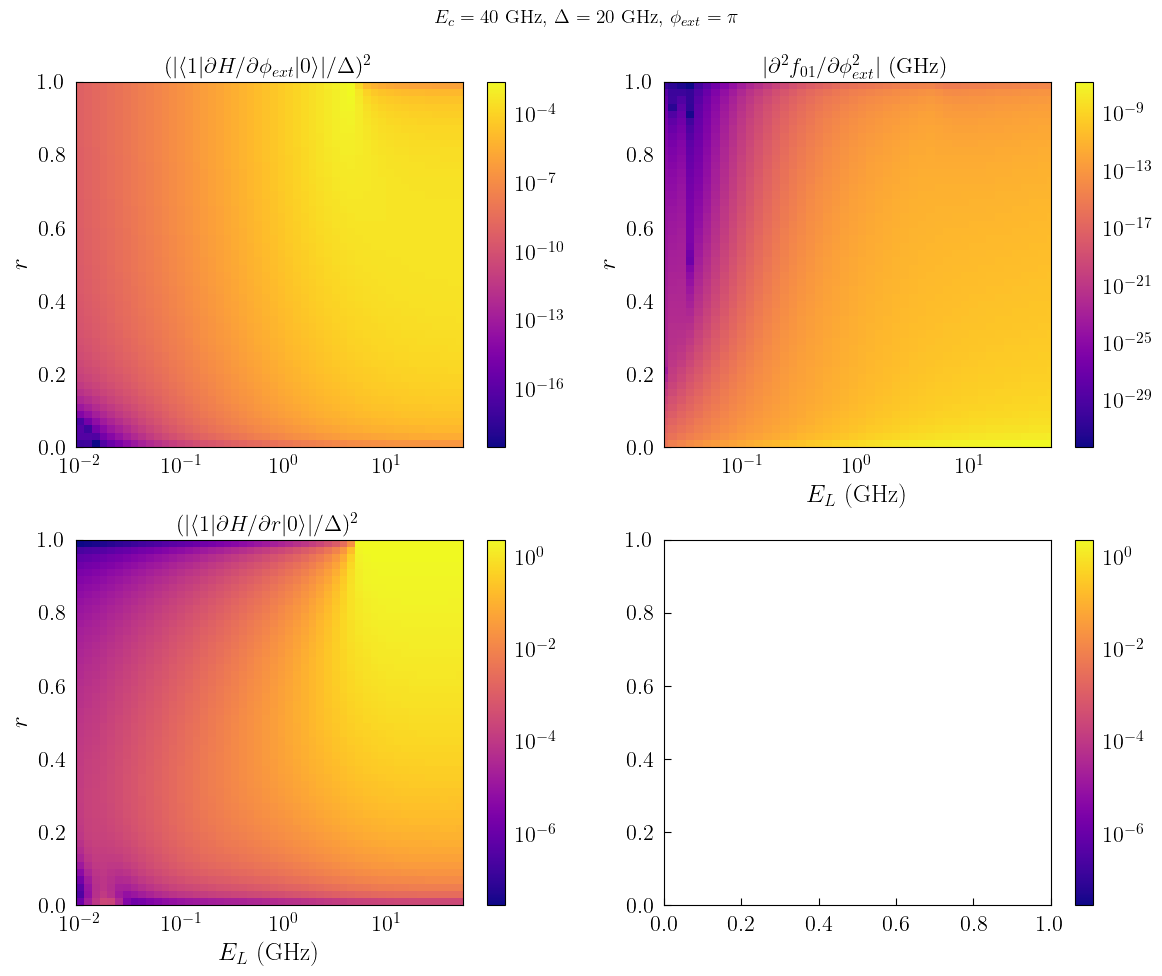

In [30]:
# Escala logarítmica para los colores
norm = colors.LogNorm()
norm2 = colors.LogNorm()
norm3 = colors.LogNorm()
norm4 = colors.LogNorm()
El_mesh, r_mesh = np.meshgrid(El_list, r_list, indexing="ij")
# Graficar phi_matrix_elements_list vs El y r
fig1, ax = plt.subplots(2,2, figsize =(12,10), sharex=False)

# put a title with the parameters values
fig1.suptitle(r"$E_c = 40$ GHz, $\Delta = 20$ GHz, $\phi_{ext} = \pi$", fontsize=14)
contour1 = ax[0,0].pcolormesh(El_mesh / 1e9, r_mesh, phi_matrix_elements_list, cmap="plasma", norm=norm)
ax[0,0].set_xscale("log")
# ax[0,0].set_yscale("log")
# ax[0,0].set_xlabel(r"$E_L$ (GHz)")
ax[0,0].set_ylabel(r"$r$")
ax[0,0].set_title(r"$(| \langle 1 | \partial H / \partial \phi_{ext} | 0 \rangle| / \Delta )^2$")
fig1.colorbar(contour1, ax=ax[0,0])

# Graficar d2E01dphi2_list vs El y r
contour2 = ax[0,1].pcolormesh(El_mesh / 1e9, r_mesh, np.abs(d2E01dphi2_list)*1e-9, cmap="plasma", norm=norm2)
ax[0,1].set_xscale("log")
# ax[0,1].set_yscale("log")
ax[0,1].set_xlim(0.02,50)
ax[0,1].set_xlabel(r"$E_L$ (GHz)")
ax[0,1].set_ylabel(r"$r$")
ax[0,1].set_title(r"$| \partial^2 f_{01} /\partial \phi_{ext}^2|$ (GHz)")
fig1.colorbar(contour2, ax=ax[0,1])

contour3 = ax[1,0].pcolormesh(El_mesh / 1e9, r_mesh, dHdr_matrix_elements_list, cmap="plasma", norm=norm3)
ax[1,0].set_xscale("log")
# ax[1,0].set_yscale("log")
ax[1,0].set_xlabel(r"$E_L$ (GHz)")
ax[1,0].set_ylabel(r"$r$")
ax[1,0].set_title(r"$(| \langle 1 | \partial H / \partial r | 0 \rangle| / \Delta )^2$")
fig1.colorbar(contour3, ax=ax[1,0])

contour4 = ax[1,1].pcolormesh(El_mesh / 1e9, r_mesh, dHdr_matrix_elements_list, cmap="plasma", norm=norm4)
ax[1,1].set_xscale("log")
# ax[1,1].set_yscale("log")
ax[1,1].set_xlabel(r"$E_L$ (GHz)")
ax[1,1].set_ylabel(r"$r$")
ax[1,1].set_title(r"$(| \langle 1 | \partial H / \partial r | 0 \rangle| / \Delta )^2$")
fig1.colorbar(contour4, ax=ax[1,1])

# Graficar dHdr_matrix_elements_list vs El y r
# contour3 = ax[2].pcolormesh(El_mesh / 1e9, r_mesh, n_matrix_elements_list*1e-9, cmap="plasma",norm=norm3)
# ax[2].set_xscale("log")
# # ax[2].set_yscale("log")
# ax[2].set_xlabel(r"$E_L$ (GHz)")
# ax[2].set_ylabel(r"$r$")
# ax[2].set_title(r"$8 E_C | \langle 1 | \hat{n} | 0 \rangle|$ (GHz)")
# fig1.colorbar(contour3, ax=ax[2])

plt.tight_layout()
# plt.savefig("r_El_sweep_Ec_40GHz_EDelta_20GHz_phi_ext_pi_bosonic.pdf")

plt.show()



In [31]:
with open("E_l_r_sweep_matrix_element_d2f01dphi2_Ec_40_Delta_20_phi_ext_pi.dat", "w") as file:
    file.write("# El\t r\t phi_matrix_elements_list\t d2E01dphi2_list\n")
    for i, El in enumerate(El_list):
        for j, r in enumerate(r_list):
            phi_matrix_element2 = phi_matrix_elements_list[i, j]
            d2E01dphi2_1 = d2E01dphi2_list[i, j]
            file.write(f"{El}\t{r}\t{phi_matrix_element2}\t{d2E01dphi2_1}\n")